In [1]:
import pandas as pd
import numpy as np
import re
import random
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import copy
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from scipy.stats import uniform
from sklearn.base import clone
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.preprocessing import MinMaxScaler, maxabs_scale

# 1. Import Data

In [2]:
train_data = pd.read_csv("combined_train_with_features.csv")
valid_data = pd.read_csv("combined_valid_with_features.csv")

In [3]:
train_data.shape

(180, 103)

In [4]:
valid_data.shape

(49, 103)

# 2. Data Scaling

In [6]:
def scale_data(data):
    
    scaler = MinMaxScaler()
    data.iloc[:,6:] = scaler.fit_transform(data.iloc[:,6:])
    
    return data

In [9]:
train_data = scale_data(train_data)
valid_data = scale_data(valid_data)

# 3. Cross Validation on training data

In [12]:
def MAE(y, y_pred):
    # y, y_pred are numpy.ndarray
    mae = sum(abs(y-y_pred)) / len(y)
    return mae

In [13]:
def split_data_index(data, K):
    
    index_arr = data.index.values
    shuffle_index_arr = copy.copy(index_arr)

    random.seed(222)
    shuffle_index_arr = shuffle_index_arr.reshape(-1,K)
    for arr in shuffle_index_arr:
        random.shuffle(arr)
    
    cv_outer = []
    for i in range(K):

        test_index = shuffle_index_arr[:,i]
        train_index = np.delete(shuffle_index_arr, i, axis=1).reshape(1,-1)[0]

        cv_outer.append([train_index, test_index])
    
    return cv_outer

In [14]:
def performance_eval(cv_outer, data):
    
    MAE_results = []
    RMSE_results = []
    MedAE_results = []
    r2_results = []
    model_params = []
    
    for train_index, test_index in cv_outer:
        
        X_train, y_train = data.iloc[train_index,6:].values, data.iloc[train_index,3].values
        X_test, y_test = data.iloc[test_index,6:].values, data.iloc[test_index,3].values
        
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
        
        model = SVR(kernel='rbf')
  
        params = {
                   'C': np.arange(100, 250, 10),
                    'epsilon': [0.0001, 0.001, 0.01],
                   'gamma' : [0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
                    }

        search = RandomizedSearchCV(model,params,cv=cv_inner,scoring='neg_mean_absolute_error',verbose=0,n_jobs=-1,n_iter=100,refit=False,\
                                   random_state=0)
        search.fit(X_train, y_train)
        
        model_params.append(search.best_params_)
    
        model.set_params(**search.best_params_)
        model.fit(X_train, y_train)
        print(search.best_params_)
        y_pred = model.predict(X_test)
        
        mae = MAE(y_test, y_pred)
        MAE_results.append(mae)
        
        rmse = mean_squared_error(y_test,y_pred,squared=False)
        RMSE_results.append(rmse)
        
        med = median_absolute_error(y_test, y_pred)
        MedAE_results.append(med)
        
        r2 = r2_score(y_test, y_pred)
        r2_results.append(r2)
        
    
    return MAE_results, RMSE_results, MedAE_results, r2_results, model_params

In [15]:
cv_outer = split_data_index(train_data, 10)
MAE_results, RMSE_results, MedAE_results, r2_results, model_params = performance_eval(cv_outer, train_data)

{'gamma': 0.01, 'epsilon': 0.001, 'C': 220}
{'gamma': 0.01, 'epsilon': 0.001, 'C': 220}
{'gamma': 0.01, 'epsilon': 0.001, 'C': 220}
{'gamma': 0.01, 'epsilon': 0.01, 'C': 210}
{'gamma': 0.01, 'epsilon': 0.001, 'C': 220}
{'gamma': 0.01, 'epsilon': 0.001, 'C': 220}
{'gamma': 0.01, 'epsilon': 0.001, 'C': 220}
{'gamma': 0.01, 'epsilon': 0.01, 'C': 210}
{'gamma': 0.01, 'epsilon': 0.001, 'C': 220}
{'gamma': 0.01, 'epsilon': 0.001, 'C': 220}


In [20]:
# MAE_results

# np.mean(MAE_results)

# RMSE_results

# np.mean(RMSE_results)

# np.mean(r2_results)

0.9779358441925983

# 4. Test on validation set

In [22]:
valid_data.head()

,metabolite,adduct,mzmed,rtmed,database.accession.code,SMILES,MaxEStateIndex,MinAbsEStateIndex,qed,MinPartialCharge,...,fr_Ndealkylation1,fr_Ndealkylation2,fr_allylic_oxid,fr_amide,fr_aryl_methyl,fr_bicyclic,fr_ester,fr_ether,fr_phos_acid,fr_unbrch_alkane
0,Acylcarnitine (12:0) - Dodecanoylcarnitine,[M+H]+,344.277684,0.901868,LMFA07070062,O(C(CCCCCCCCCCC)=O)[C@H](CC([O-])=O)C[N+](C)(C)C,0.647828,0.688651,0.518523,5.693446e-01,...,1.0,0.0,0.000000,0.0,0.0,0.0,0.333333,0.333333,0.0,0.250000
1,Lysophosphatidic acid LPA(18:2/0:0),[M-H]-,433.234137,1.388567,LMGP10050017,[C@](COP(=O)(O)O)([H])(O)COC(CCCCCCC/C=C\C/C=C...,0.522406,0.796962,0.212748,8.102200e-01,...,0.0,0.0,0.333333,0.0,0.0,0.0,0.333333,0.333333,1.0,0.250000
2,Lysophosphatidylcholine LPC(22:6/0:0),[M+H]+,568.339800,1.620000,LMGP01050056,[C@](COP(=O)([O-])OCC[N+](C)(C)C)([H])(O)COC(C...,0.610732,0.069236,0.125675,5.761018e-07,...,1.0,0.0,1.000000,0.0,0.0,0.0,0.333333,0.333333,1.0,0.000000
3,Lysophosphatidylcholine LPC(20:4/0:0),[M-CH3]-,528.308783,1.688300,LMGP01050048,[C@](COP(=O)([O-])OCC[N+](C)(C)C)([H])(O)COC(C...,0.610037,0.055279,0.098896,5.761018e-07,...,1.0,0.0,0.666667,0.0,0.0,0.0,0.333333,0.333333,1.0,0.107143
4,Acylcarnitine (20:2),[M+H]+,452.373400,2.070000,LMFA07070011,C(C([O-])=O)C(OC(CCCCCCCCC/C=C\C/C=C\CCCCC)=O)...,0.699670,0.708316,0.184461,5.693446e-01,...,1.0,0.0,0.333333,0.0,0.0,0.0,0.333333,0.333333,0.0,0.321429


In [23]:
X_train = train_data.iloc[:,6:].values
y_train = train_data.iloc[:,3].values
X_valid = valid_data.iloc[:,6:].values
y_valid = valid_data.iloc[:,3].values

In [24]:
predictions = []
for param in model_params:
    model = SVR()
    model.set_params(**param)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_valid)
    predictions.append(y_pred)

In [25]:
y_hat = list(map(lambda x: sum(x)/len(x), np.array(predictions).T))

In [26]:
r2_score(y_valid, y_hat)

0.959862923364996

In [27]:
mean_squared_error(y_valid, y_hat,squared=False)

0.4638484762508079

In [28]:
MAE(y_valid, y_hat)

0.38230360809141495

In [32]:
median_absolute_error(y_valid, y_hat)

0.35325995731752435

In [29]:
len(y_hat)

49

In [31]:
pred_df = pd.DataFrame(y_hat)
pred_df.columns = ['SVR_pred']
pred_df.to_csv("Combined_Validation_Predict_SVR.csv", index=False)

# 5. Plot y_true and y_pred

Text(0, 0.5, 'Predicted Retention Time (min)')

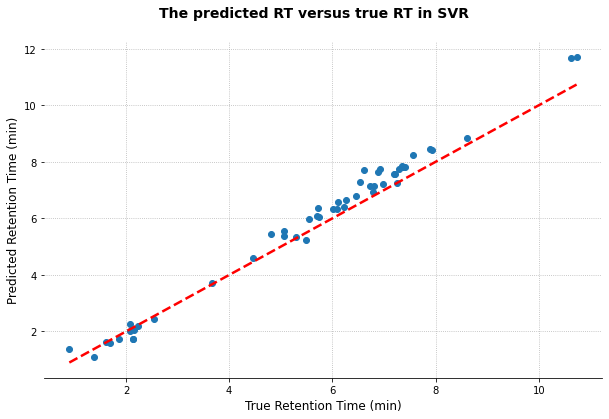

In [36]:
fig, ax = plt.subplots(figsize=(10,6.18))
fig.patch.set_facecolor('white')
ax.grid(True, which='major', linestyle=':')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot(y_valid, y_hat, 'o')
ax.plot(y_valid, y_valid, '--', color='red', linewidth=2.5)
# ax.legend()

fig.suptitle("The predicted RT versus true RT in SVR", y=0.96, fontsize=14, fontweight='bold')
ax.set_xlabel("True Retention Time (min)", fontdict={'fontsize': 12})
ax.set_ylabel("Predicted Retention Time (min)", fontdict={'fontsize': 12})

# fig.savefig("SVR_validation_pred_true.png", dpi=300)